In [ ]:
!pip install networkx
!pip install numpy
!pip install pandas
!pip install matplotlib.pyplot
!pip install scikit-learn

In [1]:
!pip uninstall torch torchvision torchtext torchdata torchaudio --yes
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0


Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchdata-0.7.0
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import networkx as nx
import pandas
print("Using torch", torch.__version__)

Using torch 2.1.0+cu121


In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00


In [4]:
import torch_cluster
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

In [6]:
import pickle
def load_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

In [7]:

email_data = load_data('Data/email_data.pkl')

In [8]:
print(email_data)

Data(x=[1005, 1], edge_index=[2, 15906], y=[1005], edge_labels=[15906], edge_attr=[15906, 1])


In [9]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.05, num_test=0.15)
email_data2= split(email_data)


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(email_data2.edge_index, embedding_dim=16, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


In [11]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)



In [ ]:
z = model()

In [ ]:
# from tensor to numpy
emb_16 = z.detach().cpu().numpy()

In [ ]:
# compute edge embedding



In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def test():
  z = model()
  edge_embedding = []
  emb_16 = z.detach().cpu().numpy()
  for u,v in email_data2.edge_index.t():
      edge_embedding.append(np.mean([emb_16[u],emb_16[v]],0))

  clf = RandomForestClassifier(max_depth=7,random_state=10)

  scores_macro = cross_val_score(clf, edge_embedding, email_data.edge_labels, cv=10, scoring='f1_macro')
  mean_f1_macro = np.mean(scores_macro)
  return mean_f1_macro

Epoch: 01, Loss: 0.8686
Epoch: 02, Loss: 0.8678
Epoch: 03, Loss: 0.8691
Epoch: 04, Loss: 0.8670
Epoch: 05, Loss: 0.8687
Epoch: 06, Loss: 0.8680
Epoch: 07, Loss: 0.8700
Epoch: 08, Loss: 0.8684
Epoch: 09, Loss: 0.8671
Epoch: 10, Loss: 0.8683
Epoch: 11, Loss: 0.8686
Epoch: 12, Loss: 0.8684
Epoch: 13, Loss: 0.8686
Epoch: 14, Loss: 0.8671
Epoch: 15, Loss: 0.8695
Epoch: 16, Loss: 0.8705
Epoch: 17, Loss: 0.8676
Epoch: 18, Loss: 0.8675
Epoch: 19, Loss: 0.8670
Epoch: 20, Loss: 0.8695
Epoch: 21, Loss: 0.8691
Epoch: 22, Loss: 0.8679
Epoch: 23, Loss: 0.8673
Epoch: 24, Loss: 0.8691
Epoch: 25, Loss: 0.8677
Epoch: 26, Loss: 0.8678
Epoch: 27, Loss: 0.8696
Epoch: 28, Loss: 0.8692
Epoch: 29, Loss: 0.8675
Epoch: 30, Loss: 0.8689
Epoch: 31, Loss: 0.8688
Epoch: 32, Loss: 0.8680
Epoch: 33, Loss: 0.8670
Epoch: 34, Loss: 0.8677
Epoch: 35, Loss: 0.8675
Epoch: 36, Loss: 0.8694
Epoch: 37, Loss: 0.8692
Epoch: 38, Loss: 0.8684
Epoch: 39, Loss: 0.8677
Epoch: 40, Loss: 0.8685
Epoch: 41, Loss: 0.8687
Epoch: 42, Loss:

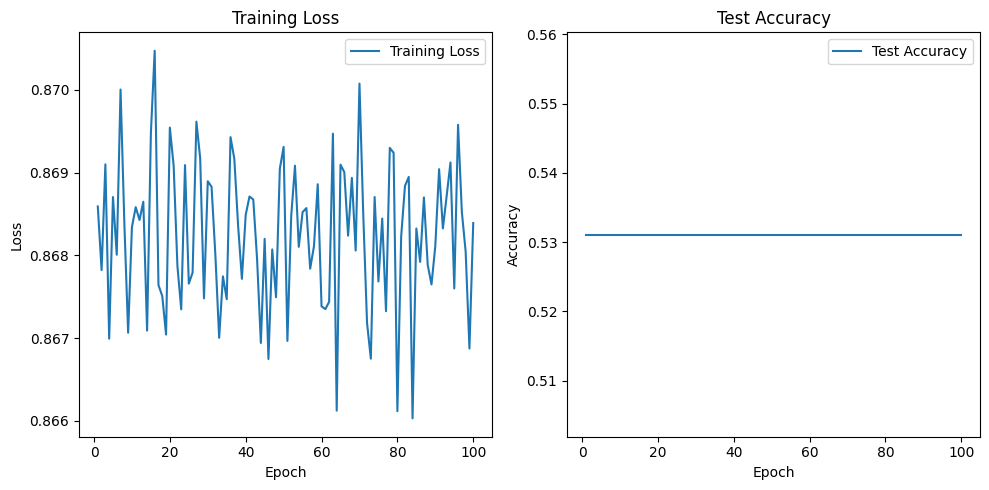

Epoch: 01, Loss: 0.8677
Epoch: 02, Loss: 0.8666
Epoch: 03, Loss: 0.8682
Epoch: 04, Loss: 0.8678
Epoch: 05, Loss: 0.8678
Epoch: 06, Loss: 0.8688
Epoch: 07, Loss: 0.8674
Epoch: 08, Loss: 0.8665
Epoch: 09, Loss: 0.8684
Epoch: 10, Loss: 0.8705
Epoch: 11, Loss: 0.8680
Epoch: 12, Loss: 0.8703
Epoch: 13, Loss: 0.8685
Epoch: 14, Loss: 0.8692
Epoch: 15, Loss: 0.8682
Epoch: 16, Loss: 0.8685
Epoch: 17, Loss: 0.8684
Epoch: 18, Loss: 0.8695
Epoch: 19, Loss: 0.8680
Epoch: 20, Loss: 0.8674
Epoch: 21, Loss: 0.8700
Epoch: 22, Loss: 0.8664
Epoch: 23, Loss: 0.8685
Epoch: 24, Loss: 0.8676
Epoch: 25, Loss: 0.8685
Epoch: 26, Loss: 0.8688
Epoch: 27, Loss: 0.8675
Epoch: 28, Loss: 0.8677
Epoch: 29, Loss: 0.8695
Epoch: 30, Loss: 0.8677
Epoch: 31, Loss: 0.8675
Epoch: 32, Loss: 0.8673
Epoch: 33, Loss: 0.8702
Epoch: 34, Loss: 0.8678
Epoch: 35, Loss: 0.8686
Epoch: 36, Loss: 0.8668
Epoch: 37, Loss: 0.8666
Epoch: 38, Loss: 0.8707
Epoch: 39, Loss: 0.8661
Epoch: 40, Loss: 0.8675
Epoch: 41, Loss: 0.8690
Epoch: 42, Loss:

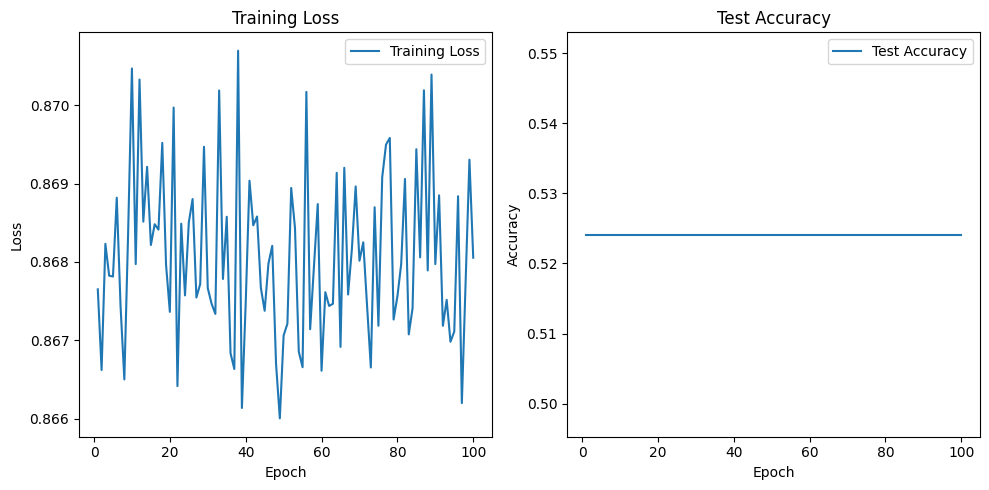

Epoch: 01, Loss: 0.8665
Epoch: 02, Loss: 0.8694
Epoch: 03, Loss: 0.8685
Epoch: 04, Loss: 0.8686
Epoch: 05, Loss: 0.8662
Epoch: 06, Loss: 0.8696
Epoch: 07, Loss: 0.8677
Epoch: 08, Loss: 0.8685
Epoch: 09, Loss: 0.8697
Epoch: 10, Loss: 0.8680
Epoch: 11, Loss: 0.8686
Epoch: 12, Loss: 0.8667
Epoch: 13, Loss: 0.8689
Epoch: 14, Loss: 0.8699
Epoch: 15, Loss: 0.8672
Epoch: 16, Loss: 0.8673
Epoch: 17, Loss: 0.8694
Epoch: 18, Loss: 0.8685
Epoch: 19, Loss: 0.8663
Epoch: 20, Loss: 0.8691
Epoch: 21, Loss: 0.8689
Epoch: 22, Loss: 0.8689
Epoch: 23, Loss: 0.8688
Epoch: 24, Loss: 0.8679
Epoch: 25, Loss: 0.8680
Epoch: 26, Loss: 0.8703
Epoch: 27, Loss: 0.8689
Epoch: 28, Loss: 0.8697
Epoch: 29, Loss: 0.8683
Epoch: 30, Loss: 0.8680
Epoch: 31, Loss: 0.8668
Epoch: 32, Loss: 0.8676
Epoch: 33, Loss: 0.8676
Epoch: 34, Loss: 0.8683
Epoch: 35, Loss: 0.8675
Epoch: 36, Loss: 0.8693
Epoch: 37, Loss: 0.8683
Epoch: 38, Loss: 0.8689
Epoch: 39, Loss: 0.8690
Epoch: 40, Loss: 0.8674
Epoch: 41, Loss: 0.8679
Epoch: 42, Loss:

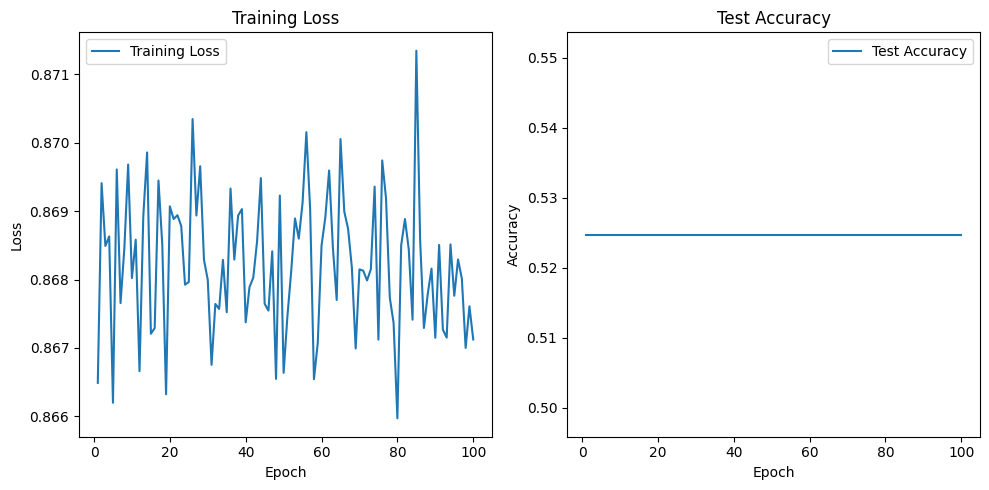

In [19]:
final_test_acc_list=[]
final_loss_list = []

for i in range(3):
  train_loss_values = []
  test_acc_values = []

  for epoch in range(1, 101):
    loss = train()
    train_loss_values.append(loss)
    test_acc_values.append(loss)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  score = test()
  print(f'Mean F1 Macro: {score}')
  final_loss_list.append(loss)
  final_test_acc_list.append(score)


  # Plotting
  epochs_range = range(1, 101)

  plt.figure(figsize=(10, 5))

  # Plotting loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_loss_values, label='Training Loss')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  test_acc_values=[score]*100
  # Plotting accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, test_acc_values, label='Test Accuracy')
  plt.title('Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [20]:
final_test_acc_list= np.array(final_test_acc_list)
final_loss_list= np.array(final_loss_list)

# Mean
loss_mean_value = np.mean(final_loss_list)
acc_mean_value = np.mean(final_test_acc_list)
print(f"loss Mean: {loss_mean_value}")
print(f"Acc Mean: {acc_mean_value}")

# Max
loss_max_value = np.max(final_loss_list)
acc_max_value = np.max(final_test_acc_list)
print(f"loss_Max: {loss_max_value}")
print(f"acc_Max: {acc_max_value}")

# Standard Deviation
loss_std_dev = np.std(final_loss_list)
acc_std_dev = np.std(final_test_acc_list)
print(f"loss_Standard Deviation: {loss_std_dev}")
print(f"acc_Standard Deviation: {acc_std_dev}")

loss Mean: 0.8678566813468933
Acc Mean: 0.5266618096953427
loss_Max: 0.868390716612339
acc_Max: 0.5310962516556257
loss_Standard Deviation: 0.0005355317120731431
acc_Standard Deviation: 0.003146130715893459
